In [ ]:
from src.database.db import Database
import pickle
import umap
from sklearn.metrics.pairwise import cosine_similarity

reducer = umap.UMAP(n_components=2, random_state=42)
db = Database()

c:\Users\giuse\Documenti\DataScience\book_library\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2026-01-24 23:07:03,650 | INFO     | book_library | db:43 | Connecting to database at c:\Users\giuse\Documenti\DataScience\book_library\data\books.db


In [2]:
with db:
    books_embeddings = db.run_query("select * from book_embeddings", as_dataframe=False)
    books_embeddings_dict =  {}
    for b in books_embeddings:
        v = pickle.loads(b.get("vector"))
        books_embeddings_dict[b.get("book_id")] = v

2026-01-24 23:07:03,658 | INFO     | book_library | db:43 | Connecting to database at c:\Users\giuse\Documenti\DataScience\book_library\data\books.db
2026-01-24 23:07:03,662 | INFO     | book_library | db:53 | Database connection closed.


In [3]:
import pandas as pd

embeddings_df = pd.DataFrame.from_dict(books_embeddings_dict, orient='index')
reduced_embeddings = reducer.fit_transform(embeddings_df.values)
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, index=embeddings_df.index, columns=['UMAP1', 'UMAP2'])

with db:
    books = db.run_query("select * from books", as_dataframe=True).merge(reduced_embeddings_df, left_on='id', right_index=True)


c:\Users\giuse\Documenti\DataScience\book_library\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2026-01-24 23:07:10,828 | INFO     | book_library | db:43 | Connecting to database at c:\Users\giuse\Documenti\DataScience\book_library\data\books.db
2026-01-24 23:07:10,832 | INFO     | book_library | db:53 | Database connection closed.


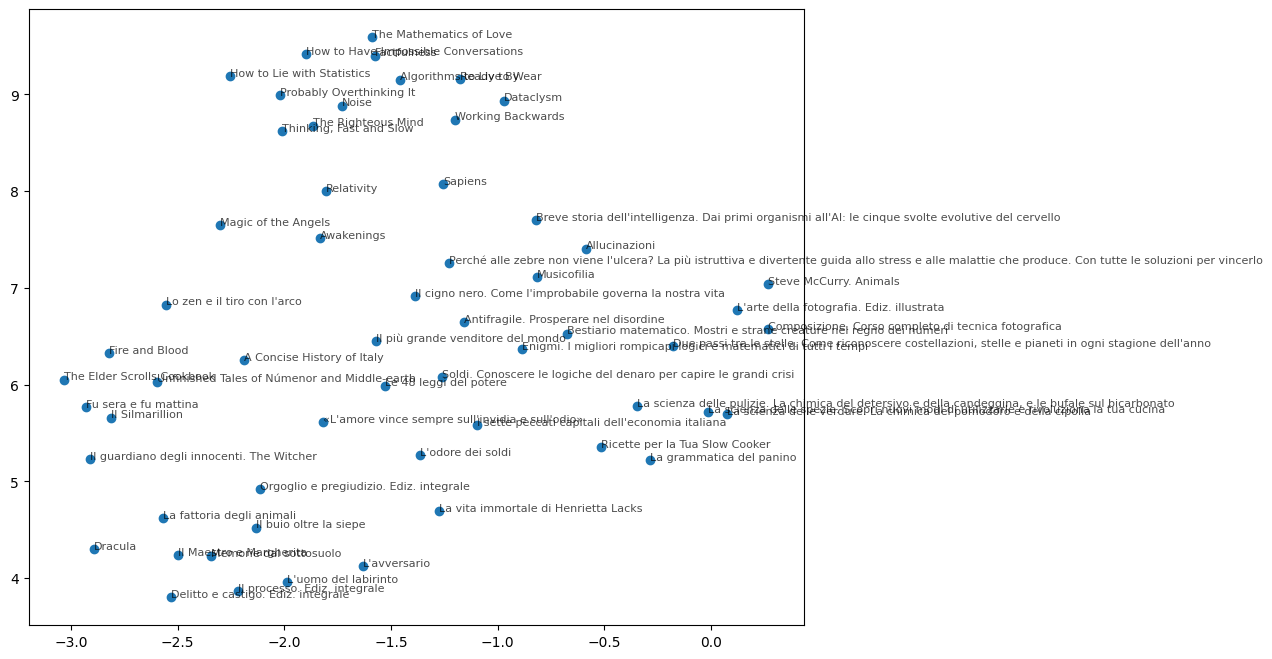

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(books['UMAP1'], books['UMAP2'])
for _, row in books.iterrows():
    ax.annotate(row['title'], (row['UMAP1'], row['UMAP2']), fontsize=8, alpha=0.7)

<Axes: >

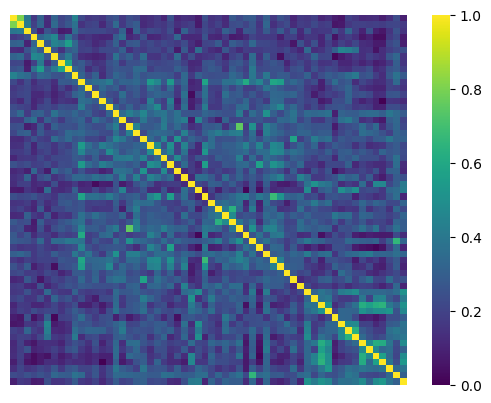

In [ ]:

similarity_matrix = cosine_similarity(embeddings_df)

sns.heatmap(similarity_matrix, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="viridis")

In [ ]:
query = """
SELECT 
    b.isbn,
    b.title,
    b.language,
    substr(b.publishedDate, 1, 4) as publishedYear,
    b.publisher,
    b.pageCount,
    a.n_authors as nAuthors,
    be.vector as embedding_vector,
    b.description
from books b
join book_embeddings be on b.id = be.book_id
join (select book_id, count(distinct author_id) as n_authors from book_authors group by book_id) a on b.id = a.book_id
where be.model_name = :model_name

"""

with db:
    books = (
        db.run_query(query, params={"model_name": "qwen3-embedding:0.6b"}, as_dataframe=True)
        .assign(embedding_vector=lambda df: df["embedding_vector"].apply(pickle.loads))
    )
    embeddings_data_books = pd.DataFrame(books["embedding_vector"].to_list(), index=books.isbn)
    similarity_matrix_books = cosine_similarity(embeddings_data_books)
    umap_books = reducer.fit_transform(embeddings_data_books)
    books = books.assign(UMAP1=umap_books[:, 0], UMAP2=umap_books[:, 1])

books

2026-01-25 10:14:50,949 | INFO     | book_library | db:43 | Connecting to database at c:\Users\giuse\Documenti\DataScience\book_library\data\books.db
2026-01-25 10:14:50,954 | INFO     | book_library | db:53 | Database connection closed.


,isbn,title,language,publishedYear,publisher,pageCount,nAuthors,embedding_vector,description
0,9788806236243,Enigmi. I migliori rompicapi logici e matemati...,it,2019,Einaudi. Stile libero extra,282.0,1,"[0.02821397, 0.03753624, -0.0035577237, -0.011...",A curated collection of the most fascinating l...
1,9788807892271,I sette peccati capitali dell'economia italiana,it,2019,None,174.0,1,"[0.005622016, 0.055679426, -0.0063929246, 0.04...",A critical analysis by economist Carlo Cottare...
2,9788804752370,Fu sera e fu mattina,it,2022,None,0.0,1,"[0.07072203, 0.013667462, -0.0040948456, 0.029...",A prequel to Ken Follett's bestselling histori...
3,9788845925351,Musicofilia,it,2010,None,0.0,1,"[0.0021110459, -0.00073669106, 0.0015002149, 0...",A 2007 book by neurologist and author Oliver S...
4,9788850263868,L'uomo del labirinto,it,2022,None,0.0,1,"[0.035371706, 0.010379642, 0.003704076, 0.0412...",A psychological thriller by Donato Carrisi fea...
5,9788850337002,Breve storia dell'intelligenza. Dai primi orga...,it,2024,None,0.0,1,"[-0.04918282, 0.03390946, 0.0010479003, 0.0874...",A neuroscience and artificial intelligence wor...
6,9788845936845,La vita immortale di Henrietta Lacks,it,2022,None,424.0,1,"[0.001493809, 0.0401915, -8.838704e-05, 0.1256...",A nonfiction work by science journalist Rebecc...
7,9780385347396,Dataclysm,en,2015,National Geographic Books,0.0,1,"[-0.06363837, 0.005527772, -0.012218702, 0.049...","A New York Times Bestseller An audacious, irre..."
8,9788845272400,Il Silmarillion,it,2013,I grandi tascabili,682.0,1,"[0.035539884, 0.07179537, -0.007005933, -0.018...",A posthumously published collection of J.R.R. ...
9,9780008402785,Fire and Blood,en,2020,Harper Voyager,0.0,1,"[0.049046766, 0.020996561, -0.010695029, 0.003...",THE INSPIRATION FOR HBO AND SKY'S HOUSE OF THE...
